#Import Libraries

In [ ]:
!pip install dill

  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)


In [ ]:
!pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 21.7 MB/s eta 0:00:00


In [ ]:
# import general libraries
# These libraries are essential for handling numerical operations (NumPy, math), geographic data (GeoPandas, Shapely), visualization (Matplotlib), and file management (pickle, os, dill).
# The research paper deals with mapping malaria prevalence across shifting administrative boundaries in Kenya. The geographic libraries help in processing shapefiles that define district/province boundaries before and after changes.
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors


# JAX: Accelerates machine learning computations, enabling efficient execution of Bayesian inference.
import jax
import jax.numpy as jnp
from jax import random, lax, jit, ops
# stax has been moved from jax.experimental to jax.example_libraries
from jax.example_libraries import stax


# Numpyro: Provides probabilistic programming functionality, allowing Bayesian inference using MCMC and Variational Inference (SVI).
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

import plotly.express as px

from termcolor import colored

# Significance: The paper proposes using deep generative models (like VAE) in combination with Bayesian inference. NumPyro facilitates the Bayesian Hierarchical Model (BHM) and MCMC sampling needed for posterior estimation.

print(jax.__version__)
print(numpyro.__version__)

0.4.33
0.17.0


#Reading in data and processing

##Read in cases data

In [ ]:
data_jkt = pd.read_csv("jakarta_data.csv")
data_java = pd.read_csv("westjava_data.csv")

In [ ]:
#rename time to year
data_java.rename(columns={'Time': 'Year'}, inplace=True)
data_jkt.rename(columns={'Time': 'Year'}, inplace=True)

In [ ]:
data_java.head()
data_jkt.head()

,District,Year,Age,Cases,Population
0,KEPULAUAN SERIBU,2020,0-4,9,2837
1,KEPULAUAN SERIBU,2020,10-14,1,2307
2,KEPULAUAN SERIBU,2020,15-19,0,2575
3,KEPULAUAN SERIBU,2020,20-44,2,11456
4,KEPULAUAN SERIBU,2020,45-54,0,3184


In [ ]:
#check the unique values of Distric for the jkt dataset
data_jkt["District"].unique()

array(['KEPULAUAN SERIBU', 'KOTA JAKARTA BARAT', 'KOTA JAKARTA PUSAT',
       'KOTA JAKARTA SELATAN', 'KOTA JAKARTA TIMUR', 'KOTA JAKARTA UTARA'],
      dtype=object)

In [ ]:
#check the unique values of Distric for the java dataset
data_java["District"].unique()

array(['BANDUNG', 'BANDUNG BARAT', 'BEKASI', 'BOGOR', 'CIAMIS', 'CIANJUR',
       'CIREBON', 'GARUT', 'INDRAMAYU', 'KARAWANG', 'KOTA BANDUNG',
       'KOTA BANJAR', 'KOTA BEKASI', 'KOTA BOGOR', 'KOTA CIMAHI',
       'KOTA CIREBON', 'KOTA DEPOK', 'KOTA SUKABUMI', 'KOTA TASIKMALAYA',
       'KUNINGAN', 'MAJALENGKA', 'PANGANDARAN', 'PURWAKARTA', 'SUBANG',
       'SUKABUMI', 'SUMEDANG', 'TASIKMALAYA'], dtype=object)

##total area data processing for jkt

In [ ]:
#read in the total area data
area_jkt_old = pd.read_csv("total_area_jkt_2020.csv")
area_jkt_new = pd.read_csv("total_area_jkt_20212023.csv")

In [ ]:
#check the files
area_jkt_old.head()

,Kab/Kota,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,The Total Area by Regency/ Municipality (Km&lt...,NaN,NaN
1,NaN,2018,2019.00,2020.00
2,Kep Seribu,8.7,10.18,10.18
3,Jakarta Selatan,141.27,154.32,154.32
4,Jakarta Timur,188.03,182.70,182.70


In [ ]:
#check the files
area_jkt_new.head()

,Kab/Kota,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,The Total Area by Regency/ Municipality (Km&lt...,NaN,NaN
1,NaN,2021,2022.00,2023.00
2,Kep Seribu,10.18,10.73,10.73
3,Jakarta Selatan,154.32,144.94,144.94
4,Jakarta Timur,182.7,185.54,185.54


In [ ]:
#data cleaning for old and new jkt files - values for the index 1 row to be colnames for cols 1-3, then eliminate the rows of index 0 and 1 --> area is in km^2
area_jkt_new.columns = area_jkt_new.iloc[1]
area_jkt_new = area_jkt_new.iloc[2:]
area_jkt_old.columns = area_jkt_old.iloc[1]
area_jkt_old = area_jkt_old.iloc[2:]

#rename the first column into District
area_jkt_new.rename(columns={np.nan: 'District'}, inplace=True)
area_jkt_old.rename(columns={np.nan: 'District'}, inplace=True)

<ipython-input-150-d70ab754d24b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_jkt_new.rename(columns={np.nan: 'District'}, inplace=True)
<ipython-input-150-d70ab754d24b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_jkt_old.rename(columns={np.nan: 'District'}, inplace=True)


In [ ]:
area_jkt_old.head()

1,District,2018,2019.0,2020.0
2,Kep Seribu,8.7,10.18,10.18
3,Jakarta Selatan,141.27,154.32,154.32
4,Jakarta Timur,188.03,182.70,182.70
5,Jakarta Pusat,48.13,52.38,52.38
6,Jakarta Barat,129.54,124.44,124.44


In [ ]:
area_jkt_new.head()

1,District,2021,2022.0,2023.0
2,Kep Seribu,10.18,10.73,10.73
3,Jakarta Selatan,154.32,144.94,144.94
4,Jakarta Timur,182.7,185.54,185.54
5,Jakarta Pusat,52.38,47.56,47.56
6,Jakarta Barat,124.44,125.00,125.00


In [ ]:
#merge both dataframew by District, and then convert to long form, then filter to get Year = 2020-2023 only
area_jkt = pd.merge(area_jkt_old, area_jkt_new, on="District", how="inner")
area_jkt = pd.melt(area_jkt, id_vars=["District"], var_name="Year", value_name="Area_sq_km")

#convert Year to integer
area_jkt["Year"] = area_jkt["Year"].astype(int)

#filter to get 2020-2023 values
area_jkt = area_jkt[area_jkt["Year"].isin([2020, 2021, 2022, 2023])]

#convert the names of District values to upper case
area_jkt["District"] = area_jkt["District"].str.upper()

#rename the value KEP SERIBU into KEPULAUAN SERIBU and add KOTA in front of the other values under the column District
area_jkt["District"] = "KOTA " + area_jkt["District"]
area_jkt.loc[area_jkt["District"] == "KOTA KEP SERIBU", "District"] = "KEPULAUAN SERIBU"

In [ ]:
#check df
area_jkt.head()

,District,Year,Area_sq_km
14,KEPULAUAN SERIBU,2020,10.18
15,KOTA JAKARTA SELATAN,2020,154.32
16,KOTA JAKARTA TIMUR,2020,182.7
17,KOTA JAKARTA PUSAT,2020,52.38
18,KOTA JAKARTA BARAT,2020,124.44


##total area data processing for west java

In [ ]:
area_java = pd.read_csv("total_area_westjava.csv")

area_java.head()

,Regency/Municipality,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Total Area (sq. km),NaN,NaN,NaN
1,NaN,2022,2021.00,2019.00,2018.00
2,Jawa Barat Province,35377.76,35377.76,35377.76,35377.76
3,Bogor,2710.62,2710.62,2710.62,2710.62
4,Sukabumi,4145.7,4145.70,4145.70,4145.70


In [ ]:
#make the values for row index 1 become column values
area_java.columns = area_java.iloc[1]
area_java = area_java.iloc[2:]

#rename the col 1 to be "District" instead of NaN
area_java.rename(columns={np.nan: 'District'}, inplace=True)

#reformat to long
area_java = pd.melt(area_java, id_vars=["District"], var_name="Year", value_name="Area_sq_km")

#eliminate the Year column here because all the area values are the same
area_java = area_java.drop(columns=["Year"])

#convert the names of District values to upper case
area_java["District"] = area_java["District"].str.upper()

#rewrite the values of District --> for values with MUNICIPALITY at the back, eliminate the MUNICIPALITY and add KOTA at the front of only the values previously containing municipality
area_java.loc[area_java["District"].str.contains("MUNICIPALITY"), "District"] = "KOTA " + area_java["District"].str.replace("MUNICIPALITY", "")


#check the dataframe format
area_java.head()

<ipython-input-155-14cdee2d6a40>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_java.rename(columns={np.nan: 'District'}, inplace=True)


,District,Area_sq_km
0,JAWA BARAT PROVINCE,35377.76
1,BOGOR,2710.62
2,SUKABUMI,4145.7
3,CIANJUR,3840.16
4,BANDUNG,1767.96


In [ ]:
area_java["District"].unique()

array(['JAWA BARAT PROVINCE', 'BOGOR', 'SUKABUMI', 'CIANJUR', 'BANDUNG',
       'GARUT', 'TASIKMALAYA', 'CIAMIS', 'KUNINGAN', 'CIREBON',
       'MAJALENGKA', 'SUMEDANG', 'INDRAMAYU', 'SUBANG', 'PURWAKARTA',
       'KARAWANG', 'BEKASI', 'BANDUNG BARAT', 'PANGANDARAN',
       'KOTA BOGOR ', 'KOTA SUKABUMI ', 'KOTA BANDUNG ', 'KOTA CIREBON ',
       'KOTA BEKASI ', 'KOTA DEPOK ', 'KOTA CIMAHI ', 'KOTA TASIKMALAYA ',
       'KOTA BANJAR '], dtype=object)

In [ ]:
#merge the jkt and java datasets to the df_long dataset by District and Year to add the population density column
data_java = data_java.merge(area_java, on=["District"], how="left")
data_jkt = data_jkt.merge(area_jkt, on=["District", "Year"], how="left")

In [ ]:
#convert population and area to integer
data_java["Population"] = data_java["Population"].astype(int)
data_jkt["Population"] = data_jkt["Population"].astype(int)

#convert the area_sq_km values into
data_java["Area_sq_km"] = data_java["Area_sq_km"].astype(float)
data_jkt["Area_sq_km"] = data_jkt["Area_sq_km"].astype(float)
data_java["Pop_density"] = data_java["Population"] / data_java["Area_sq_km"]
data_jkt["Pop_density"] = data_jkt["Population"] / data_jkt["Area_sq_km"]

In [ ]:
data_jkt.head()

,District,Year,Age,Cases,Population,Area_sq_km,Pop_density
0,KEPULAUAN SERIBU,2020,0-4,9,2837,10.18,278.683694
1,KEPULAUAN SERIBU,2020,10-14,1,2307,10.18,226.620825
2,KEPULAUAN SERIBU,2020,15-19,0,2575,10.18,252.946955
3,KEPULAUAN SERIBU,2020,20-44,2,11456,10.18,1125.343811
4,KEPULAUAN SERIBU,2020,45-54,0,3184,10.18,312.770138


In [ ]:
#read in HDI data
data_hdi_old = pd.read_csv("hdi_2019-2021.csv")
data_hdi_new = pd.read_csv("hdi_2019-2021.csv")

In [ ]:
data_hdi_old.head()

,Province/Regency/City,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,[New Method] Human Development Index,NaN,NaN
1,NaN,2019,2020,2021
2,ACEH,71.9,71.99,72.18
3,Simeulue,65.7,66.03,66.41
4,Aceh Singkil,68.91,68.94,69.22


In [ ]:
#the colnames of the index 1 row to be colnames
data_hdi_new.columns = data_hdi_new.iloc[1]
data_hdi_new = data_hdi_new.iloc[2:]
data_hdi_old.columns = data_hdi_old.iloc[1]
data_hdi_old = data_hdi_old.iloc[2:]
#rename the first column to "District"
data_hdi_new.rename(columns={np.nan: 'District'}, inplace=True)
data_hdi_old.rename(columns={np.nan: 'District'}, inplace=True)

<ipython-input-189-ad7131e1dfb5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hdi_new.rename(columns={np.nan: 'District'}, inplace=True)
<ipython-input-189-ad7131e1dfb5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hdi_old.rename(columns={np.nan: 'District'}, inplace=True)


In [ ]:
data_hdi_old.head()

1,District,2019,2020,2021
2,ACEH,71.9,71.99,72.18
3,Simeulue,65.7,66.03,66.41
4,Aceh Singkil,68.91,68.94,69.22
5,Aceh Selatan,66.9,67.12,67.44
6,Aceh Tenggara,69.36,69.37,69.44


In [ ]:
#convert from wide to long for both
data_hdi_new = pd.melt(data_hdi_new, id_vars=["District"], var_name="Year", value_name="HDI")
data_hdi_old = pd.melt(data_hdi_old, id_vars=["District"], var_name="Year", value_name="HDI")

#merge both
data_hdi = pd.merge(data_hdi_new, data_hdi_old, on=["District", "Year"], how="inner")

#convert Year to integer
data_hdi["Year"] = data_hdi["Year"].astype(int)

In [ ]:
#delete either HDI_x or HDI_y and rename to HDI
data_hdi = data_hdi.drop(columns=["HDI_y"])
data_hdi = data_hdi.rename(columns={"HDI_x": "HDI"})

#check
data_hdi.head()

,District,Year,HDI
0,ACEH,2019,71.9
1,Simeulue,2019,65.7
2,Aceh Singkil,2019,68.91
3,Aceh Selatan,2019,66.9
4,Aceh Tenggara,2019,69.36


In [ ]:
#rename Kep.Seribu into kepulauan seribu
data_hdi.loc[data_hdi["District"] == "Kep. Seribu", "District"] = "Kepulauan Seribu"

#convert the values of District column into all upper case
data_hdi["District"] = data_hdi["District"].str.upper()

#check again

data_hdi.head()

,District,Year,HDI
0,ACEH,2019,71.9
1,SIMEULUE,2019,65.7
2,ACEH SINGKIL,2019,68.91
3,ACEH SELATAN,2019,66.9
4,ACEH TENGGARA,2019,69.36


In [ ]:
#merge the hdi data with the data_java and data_jakarta
data_java = data_java.merge(data_hdi, on=["District", "Year"], how="left")
data_jkt = data_jkt.merge(data_hdi, on=["District", "Year"], how="left")

In [ ]:
#check
data_java.head()

,District,Year,Age,Cases,Population,Area_sq_km,Pop_density,HDI
0,BANDUNG,2020,0-4,332,313554,1767.96,177.35356,72.39
1,BANDUNG,2020,0-4,332,313554,1767.96,177.35356,72.39
2,BANDUNG,2020,0-4,332,313554,1767.96,177.35356,72.39
3,BANDUNG,2020,0-4,332,313554,1767.96,177.35356,72.39
4,BANDUNG,2020,15-44,950,1772345,1767.96,1002.48026,72.39


In [ ]:
#check
data_jkt.head()

,District,Year,Age,Cases,Population,Area_sq_km,Pop_density,HDI
0,KEPULAUAN SERIBU,2020,0-4,9,2837,10.18,278.683694,71.63
1,KEPULAUAN SERIBU,2020,10-14,1,2307,10.18,226.620825,71.63
2,KEPULAUAN SERIBU,2020,15-19,0,2575,10.18,252.946955,71.63
3,KEPULAUAN SERIBU,2020,20-44,2,11456,10.18,1125.343811,71.63
4,KEPULAUAN SERIBU,2020,45-54,0,3184,10.18,312.770138,71.63


#Read in shp file (district-level) for Indonesia

In [ ]:
df_shp_dist = gpd.read_file("adm2.shp")

In [ ]:
print(df_shp_dist.head())  # Displays the first 5 rows

           ADM2_EN          x         y  \
0       Aceh Barat  96.185453  4.456643   
1  Aceh Barat Daya  96.878320  3.824899   
2       Aceh Besar  95.515608  5.379938   
3        Aceh Jaya  95.678706  4.832184   
4     Aceh Selatan  97.435351  3.162864   

                                            geometry  
0  POLYGON ((96.26836 4.768, 96.26822 4.7625, 96....  
1  MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7...  
2  MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2...  
3  MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6...  
4  MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8...  


In [ ]:
print(df_shp_dist["ADM2_EN"].unique())  # Replace "shape1" with the suspected column name

['Aceh Barat' 'Aceh Barat Daya' 'Aceh Besar' 'Aceh Jaya' 'Aceh Selatan'
 'Aceh Singkil' 'Aceh Tamiang' 'Aceh Tengah' 'Aceh Tenggara' 'Aceh Timur'
 'Aceh Utara' 'Agam' 'Alor' 'Asahan' 'Asmat' 'Badung' 'Balangan' 'Bandung'
 'Bandung Barat' 'Banggai' 'Banggai Kepulauan' 'Banggai Laut' 'Bangka'
 'Bangka Barat' 'Bangka Selatan' 'Bangka Tengah' 'Bangkalan' 'Bangli'
 'Banjar' 'Banjarnegara' 'Bantaeng' 'Bantul' 'Banyu Asin' 'Banyumas'
 'Banyuwangi' 'Barito Kuala' 'Barito Selatan' 'Barito Timur'
 'Barito Utara' 'Barru' 'Batang' 'Batang Hari' 'Batu Bara' 'Bekasi'
 'Belitung' 'Belitung Timur' 'Belu' 'Bener Meriah' 'Bengkalis'
 'Bengkayang' 'Bengkulu Selatan' 'Bengkulu Tengah' 'Bengkulu Utara'
 'Berau' 'Biak Numfor' 'Bima' 'Bintan' 'Bireuen' 'Blitar' 'Blora'
 'Boalemo' 'Bogor' 'Bojonegoro' 'Bolaang Mongondow'
 'Bolaang Mongondow Selatan' 'Bolaang Mongondow Timur'
 'Bolaang Mongondow Utara' 'Bombana' 'Bondowoso' 'Bone' 'Bone Bolango'
 'Boven Digoel' 'Boyolali' 'Brebes' 'Buleleng' 'Bulukumba' 'Bulun

In [ ]:
#rename shape1 to District
df_shp_dist.rename(columns={'ADM2_EN': 'District'}, inplace=True)

#convert the values of the column District to all caps
df_shp_dist["District"] = df_shp_dist["District"].str.upper()

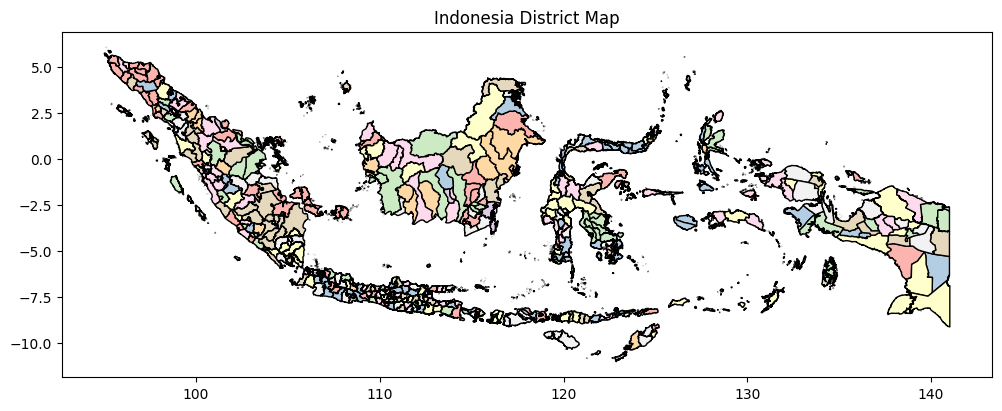

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
df_shp_dist.plot(ax=ax, edgecolor="black", cmap="Pastel1")

plt.title("Indonesia District Map")
plt.show()

#Combine shp and dengue data

In [ ]:
#combine shp file with dengue data
##aim: get a single shp file that contains ONLY the coordinates for Jawa and the districts within Jawa
df_combined_java = df_shp_dist.merge(data_java, left_on="District", right_on="District")

#check
df_combined_java.head()

,District,x,y,geometry,Year,Age,Cases,Population,Area_sq_km,Pop_density,HDI
0,BANDUNG,107.610841,-7.099969,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2020,0-4,332,313554,1767.96,177.35356,72.39
1,BANDUNG,107.610841,-7.099969,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2020,0-4,332,313554,1767.96,177.35356,72.39
2,BANDUNG,107.610841,-7.099969,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2020,0-4,332,313554,1767.96,177.35356,72.39
3,BANDUNG,107.610841,-7.099969,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2020,0-4,332,313554,1767.96,177.35356,72.39
4,BANDUNG,107.610841,-7.099969,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2020,15-44,950,1772345,1767.96,1002.48026,72.39


In [ ]:
#combine shp file with dengue data
##aim: get a single shp file that contains ONLY the coordinates for jkt and the districts within jkt
df_combined_jkt = df_shp_dist.merge(data_jkt, left_on="District", right_on="District")

#check
df_combined_jkt.head()

,District,x,y,geometry,Year,Age,Cases,Population,Area_sq_km,Pop_density,HDI
0,KEPULAUAN SERIBU,106.579356,-5.700151,"MULTIPOLYGON (((106.73563 -6.04014, 106.73548 ...",2020,0-4,9,2837,10.18,278.683694,71.63
1,KEPULAUAN SERIBU,106.579356,-5.700151,"MULTIPOLYGON (((106.73563 -6.04014, 106.73548 ...",2020,10-14,1,2307,10.18,226.620825,71.63
2,KEPULAUAN SERIBU,106.579356,-5.700151,"MULTIPOLYGON (((106.73563 -6.04014, 106.73548 ...",2020,15-19,0,2575,10.18,252.946955,71.63
3,KEPULAUAN SERIBU,106.579356,-5.700151,"MULTIPOLYGON (((106.73563 -6.04014, 106.73548 ...",2020,20-44,2,11456,10.18,1125.343811,71.63
4,KEPULAUAN SERIBU,106.579356,-5.700151,"MULTIPOLYGON (((106.73563 -6.04014, 106.73548 ...",2020,45-54,0,3184,10.18,312.770138,71.63


In [ ]:
fold_p = "data/processed/java"
fold_q = "data/processed/jkt"
file_n = "westjava_district_divisions"
file_m = "jkt_district_divisions"

# Create the directory if it doesn't exist
if not os.path.exists(fold_p):
    os.makedirs(fold_p)

if not os.path.exists(fold_q):
  os.makedirs(fold_q)

# Save the GeoDataFrame as a shapefile
file_path = os.path.join(fold_p, file_n)
file_path_1 = os.path.join(fold_q, file_m)

<ipython-input-215-6d5183ccf233>:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_combined_java.to_file(file_path, driver='ESRI Shapefile')  # Specify the driver


IsADirectoryError: [Errno 21] Is a directory: 'data/processed/westjava_district_divisions'

In [ ]:
df_combined_java.to_file(file_path, driver='ESRI Shapefile')  # Specify the driver

In [ ]:
df_combined_jkt.to_file(file_path_1, driver='ESRI Shapefile')  # Specify the driver

<ipython-input-217-1a95cb6a10b5>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_combined_jkt.to_file(file_path_1, driver='ESRI Shapefile')  # Specify the driver
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Pop_density' to 'Pop_densit'
  ogr_write(
